<a href="https://colab.research.google.com/github/marcuuus/AMD-SM2L-20-21-RIVA/blob/main/progettoV0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DOWNLOAD OF THE DATASET.

In [ ]:
!mkdir /root/.kaggle

In [ ]:
!echo '{"username":"marcuus96","key":"ca8a06de4d10013b1a150c0e7026cf37"}' > /root/.kaggle/kaggle.json

In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download jeffheaton/glasses-or-no-glasses

100% 6.11G/6.11G [02:13<00:00, 25.7MB/s]
100% 6.11G/6.11G [02:13<00:00, 49.2MB/s]


In [ ]:
!unzip /content/glasses-or-no-glasses.zip

Output streaming troncato alle ultime 5000 righe.
  inflating: faces-spring-2020/faces-spring-2020/face-1000.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1001.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1002.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1003.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1004.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1005.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1006.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1007.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1008.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1009.png  
  inflating: faces-spring-2020/faces-spring-2020/face-101.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1010.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1011.png  
  inflating: faces-spring-2020/faces-spring-2020/face-1012.png  
  inflating: faces-spring-2020/faces-spri

DATASET PREPARATION AND DATA CLEANING.

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from matplotlib import pyplot as plt
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import itertools
from IPython.display import display, Javascript, clear_output, HTML

from ipywidgets import interact
import ipywidgets as widgets

import os, re, math, json, shutil, pprint

The test set doesn't have a label associated to the image, so the first thing to do is create one for all the test images.

The second thing to do is check the correcteness of the labels in the train set. I noticed that some labels in the train set are wrong, so I checked by hand if each label was right. I created a text file with the new labels, named label_train.txt (attached in the github repository), and I uploaded it in the notebook. I did the same thing for the test's labels

In [ ]:
!npx degit https://github.com/marcuuus/AMD-SM2L-20-21-RIVA -f

npx: installed 1 in 2.643s
> destination directory is not empty. Using --force, continuing
> cloned marcuuus/AMD-SM2L-20-21-RIVA#HEAD


In [ ]:
# Creation of the test label list
with open("/content/test_labels.txt", "r") as tl:
  label_test_list = tl.readlines()
label_test_list = [x.strip() for x in label_test_list]

In [ ]:
# Creation of the train label list
with open("/content/train_labels.txt", "r") as tl:
  label_train_list = tl.readlines()
label_train_list = [x.strip() for x in label_train_list]

In [ ]:
# Creation of the label column named "glasses" in test.csv. a new csv file is created

def add_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  df['glasses'] = input_file
  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [ ]:
add_csv_column('test.csv', label_test_list)

In [ ]:
# Correction of the label column in train.csv. a new csv file is created

def modify_csv_column(csv_file, input_file):
  df = pd.read_csv(csv_file)
  
  for i in itertools.count(0):
    if i == len(input_file):
      break
    df.loc[i, 'glasses'] = input_file[i]

  df.to_csv('/content/new_' + csv_file, float_format='%.6g', index = False)

In [ ]:
modify_csv_column('train.csv', label_train_list)

CREATION OF THE DATASET

Using pandas, I create two datadrame for each set (one for the label and one for the features). I also create a dictionary to store the ID of the image, used in a second moment to visualize the neural network predictions.

During the chek of the images I noticed that some of them were really ambiguous, so I remove them from the dataset.

In [ ]:
train_file_path = "/content/new_train.csv"
test_file_path = "/content/new_test.csv"

In [ ]:
training_features = pd.read_csv(train_file_path).copy()
training_features = training_features.set_index('id')

# Drop ambiguous images (I set the label value to -1)
training_features = training_features.drop(training_features[training_features['glasses'] == -1].index)

training_labels = training_features.pop('glasses')
training_dict = training_features.T.to_dict('list')
training_features.reset_index(drop=True, inplace=True)
training_labels.reset_index(drop=True, inplace=True)

In [ ]:
test_features = pd.read_csv(test_file_path).copy()
test_features = test_features.set_index('id')

# Drop ambiguous images (I set the label value to -1)
test_features = test_features.drop(test_features[test_features['glasses'] == -1].index)

test_labels = test_features.pop('glasses')
test_dict = test_features.T.to_dict('list')
test_features.reset_index(drop=True, inplace=True)
test_labels.reset_index(drop=True, inplace=True)

I'm using the tensorflow method "tf.data.Dataset.from_tensor_slices" to create the dataset.

SPIEGARE SHUFFLE, BATCH E PREFETCH

In [ ]:
BATCH_SIZE = 128
EPOCHS = 12

In [ ]:
def get_training_ds(train_features, train_labels):
  dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels))
  dataset = dataset.repeat()
  dataset = dataset.shuffle(len(train_labels), reshuffle_each_iteration=True).batch(BATCH_SIZE)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)

  return dataset

def get_validation_ds(test_features, test_labels):
  dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels))
  dataset = dataset.repeat()
  dataset = dataset.batch(len(test_labels), drop_remainder=True)

  return dataset

EXAMPLE OF VISUALIZATION

using the train set, I visualize a list of couple (image, label)

In [ ]:
def visualize_image(images, labels, diz, num):

  path = list()

  for i in itertools.count(0):
    if i == num:
      break

    else:
      features = images[i].tolist()
      label = labels[i]
      for id_image, image in diz.items():

        if all(features[x] == image[x] if len(features) == len(image) else False for x in range(len(image))):
          id = id_image
          break

      path.append(("/content/faces-spring-2020/faces-spring-2020/face-"+str(id)+".png", label))
  
  y = 5
  x = int(math.ceil(len(path)/y))
  x_img = 0
  y_img =0

  f, axarr = plt.subplots(x,y, figsize=(20,20))
  plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=(num/5)/2.3, wspace=0.1, hspace=-0.7)
  
  for img in path:
    if x == 1:
      if img[1] == 1:
        axarr[x_img].set_title("GLASSES "+str(id), fontsize = 20)
      else:
        axarr[x_img].set_title("NO GLASSES "+str(id), fontsize = 20)

      axarr[x_img].axis("off")
      axarr[x_img].imshow(mpimg.imread(img[0]))
    
    else:

      if y_img == y:
        y_img = 0
        x_img += 1

      if img[1] == 1:
        axarr[x_img,y_img].set_title("GLASSES", fontsize = 20)
      else:
        axarr[x_img,y_img].set_title("NO GLASSES", fontsize = 20)

      axarr[x_img,y_img].axis("off")
      axarr[x_img,y_img].imshow(mpimg.imread(img[0]))

    y_img += 1

  if (y_img-1) != (y-1):
    while(y_img != y):
      f.delaxes(axarr[x-1][y_img])
      y_img += 1


In [ ]:
ex = get_training_ds(training_features, training_labels)

for example in ex.take(1):
  images, labels = example
  break

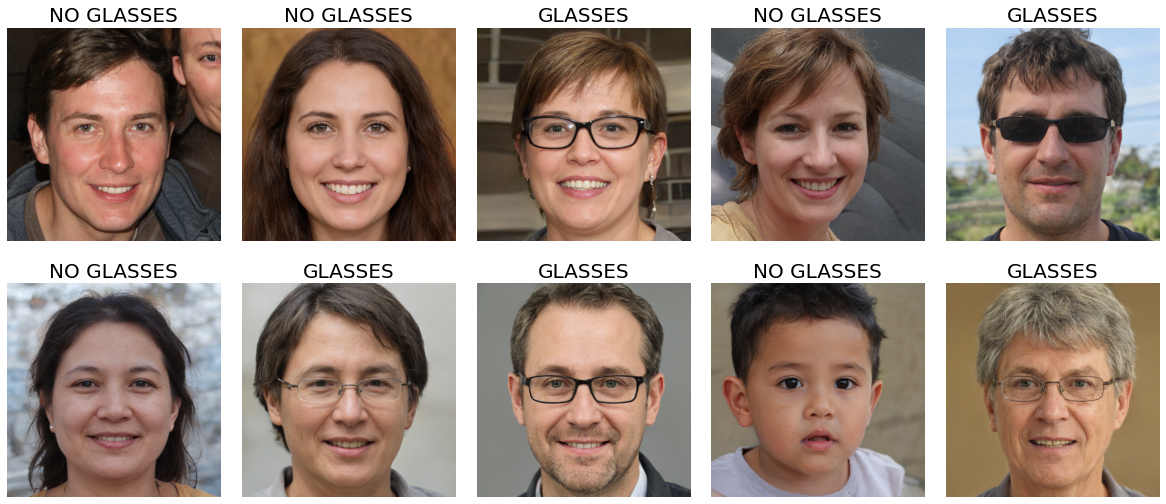

In [ ]:
 visualize_image(images[0:100].numpy(), labels[0:100].numpy(), training_dict, 10)

In [ ]:
class PlotTraining(tf.keras.callbacks.Callback):
  def __init__(self, sample_rate=1, zoom=1):
    self.sample_rate = sample_rate
    self.step = 0
    self.zoom = zoom
    self.steps_per_epoch = 4500//BATCH_SIZE

  def on_train_begin(self, logs={}):
    self.batch_history = {}
    self.batch_step = []
    self.epoch_history = {}
    self.epoch_step = []
    self.fig, self.axes = plt.subplots(1, 2, figsize=(16, 7))
    plt.ioff()

  def on_batch_end(self, batch, logs={}):
    if (batch % self.sample_rate) == 0:
      self.batch_step.append(self.step)
      for k,v in logs.items():
        # do not log "batch" and "size" metrics that do not change
        # do not log training accuracy "acc"
        if k=='batch' or k=='size':# or k=='acc':
          continue
        self.batch_history.setdefault(k, []).append(v)
    self.step += 1

  def on_epoch_end(self, epoch, logs={}):
    plt.close(self.fig)
    self.axes[0].cla()
    self.axes[1].cla()
      
    self.axes[0].set_ylim(0, 1.2/self.zoom)
    self.axes[1].set_ylim(1-1/self.zoom/2, 1+0.1/self.zoom/2)
    
    self.epoch_step.append(self.step)
    for k,v in logs.items():
      # only log validation metrics
      if not k.startswith('val_'):
        continue
      self.epoch_history.setdefault(k, []).append(v)

    clear_output(wait=True)
    
    for k,v in self.batch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.batch_step) / self.steps_per_epoch, v, label=k))
      
    for k,v in self.epoch_history.items():
      (self.axes[0 if k.endswith('loss') else 1]
           .plot(np.array(self.epoch_step) / self.steps_per_epoch, v,
                 label=k, linewidth=3))
      
    self.axes[0].legend()
    self.axes[1].legend()
    self.axes[0].set_xlabel('epochs')
    self.axes[1].set_xlabel('epochs')
    self.axes[0].minorticks_on()
    self.axes[0].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[0].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    self.axes[1].minorticks_on()
    self.axes[1].grid(True, which='major', axis='both',
                      linestyle='-', linewidth=1)
    self.axes[1].grid(True, which='minor', axis='both',
                      linestyle=':', linewidth=0.5)
    display(self.fig)


FIRST BASIC MODEL: ONE LAYER WITH ONE NEURON

activation sigmoid perchè il problema è una classificazoine binaria (motivo anche della loss), l'optimizer è subito adam e funziona bene con quello

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(512,)),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 1)                 513       
Total params: 513
Trainable params: 513
Non-trainable params: 0
_________________________________________________________________


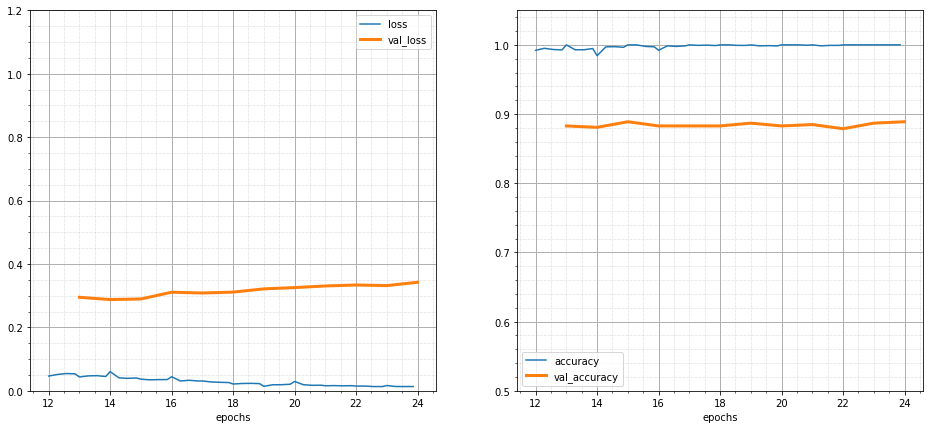

In [ ]:
steps_per_epoch = 4500//BATCH_SIZE  # 4500 items in this dataset

training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training]
                    )

SECOND MODEL: MORE LAYER WITH RELU ACTIVATION FUNC

In [ ]:
#si usa relu al posto di sigmoid
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(512,)),
      #tf.keras.layers.Dense(70, activation='relu'),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

#adam si usa per un particolare processo di ottimizzazione
#i punti di sella sono critici perchè il gradiente è nullo, adam ricorda gli update delle iterazioni
#precedenti e opera in modo da non avere problemi con i punti di sella
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 51,401
Trainable params: 51,401
Non-trainable params: 0
_________________________________________________________________


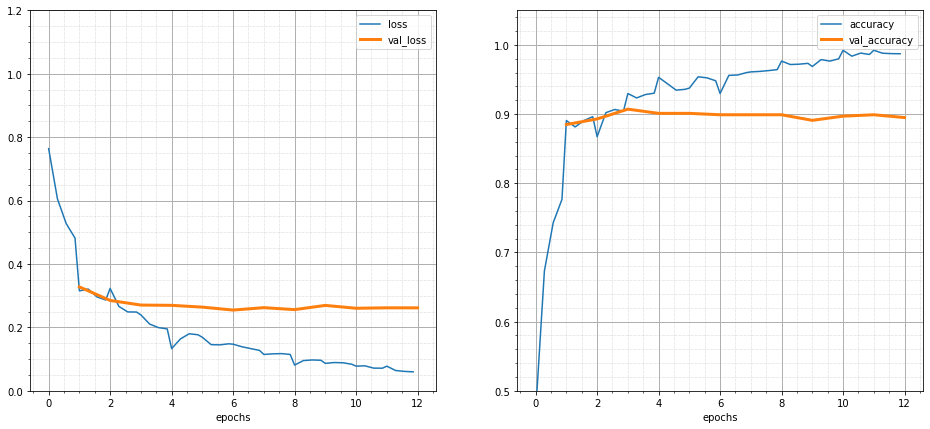

In [ ]:
training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training]
                    )

In [ ]:
def plot_learning_rate(lr_func, epochs):
  xx = np.arange(epochs+1, dtype=np.float)
  y = [lr_decay(x) for x in xx]
  fig, ax = plt.subplots(figsize=(9, 6))
  ax.set_xlabel('epochs')
  ax.set_title('Learning rate\ndecays from {:0.3g} to {:0.3g}'.format(y[0],
                                                                      y[-2]))
  ax.minorticks_on()
  ax.grid(True, which='major', axis='both', linestyle='-', linewidth=1)
  ax.grid(True, which='minor', axis='both', linestyle=':', linewidth=0.5)
  ax.step(xx,y, linewidth=3, where='post')
  display(fig)

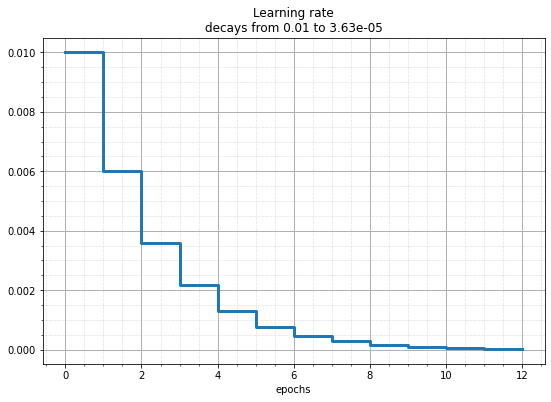

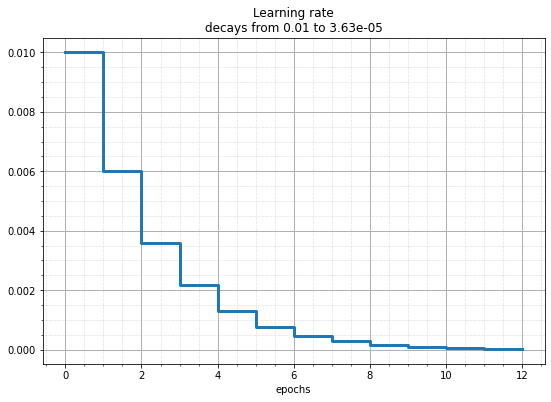

In [ ]:
# lr decay function
def lr_decay(epoch):
  return 0.01 * math.pow(0.6, epoch)

# lr schedule callback
lr_decay_callback = tf.keras.callbacks.LearningRateScheduler(lr_decay, verbose=True)


THIRD MODEL: ADDING OF DECREASING LEARNING RATE

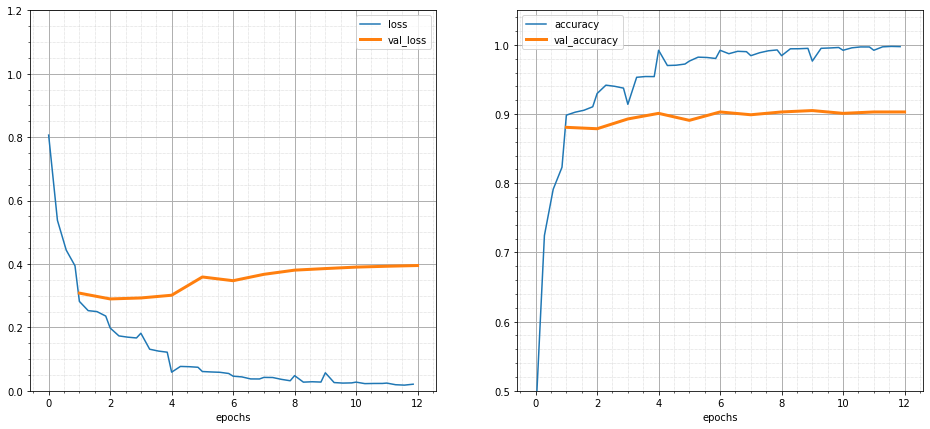

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(512,)),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

plot_training = PlotTraining(sample_rate=10, zoom=1)

training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

#specifico nel callback lr_decay, con il procedere del learning il learning rate diinuisce
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

FOURTH MODEL:

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Input(shape=(512,)),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(50, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.Dropout(0.25),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_64 (Dense)             (None, 100)               51300     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_65 (Dense)             (None, 50)                5050      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_66 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_11 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_67 (Dense)             (None, 1)               

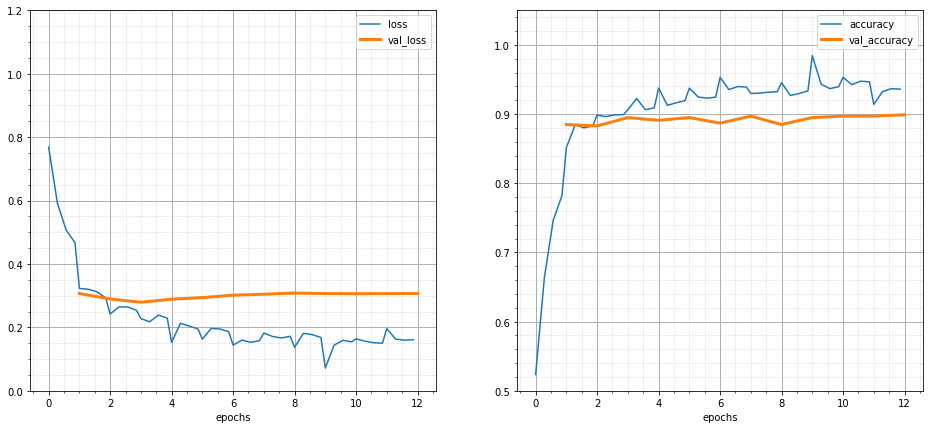

In [ ]:
training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

#specifico nel callback lr_decay, con il procedere del learning il learning rate diinuisce
history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

FIFTH MODEL: CNN

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(512,), target_shape=(16, 16, 2)),
      tf.keras.layers.Conv2D(kernel_size=4, filters=12, padding ='same',
                             activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=8, filters=24,
                             activation='relu', padding ='same', strides=2),
      tf.keras.layers.Conv2D(kernel_size=8, filters=32,
                             activation='relu', padding ='same', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 16, 16, 12)        396       
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 8, 8, 24)          18456     
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 4, 4, 32)          49184     
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_58 (Dense)             (None, 100)               51300     
_________________________________________________________________
dense_59 (Dense)             (None, 1)               

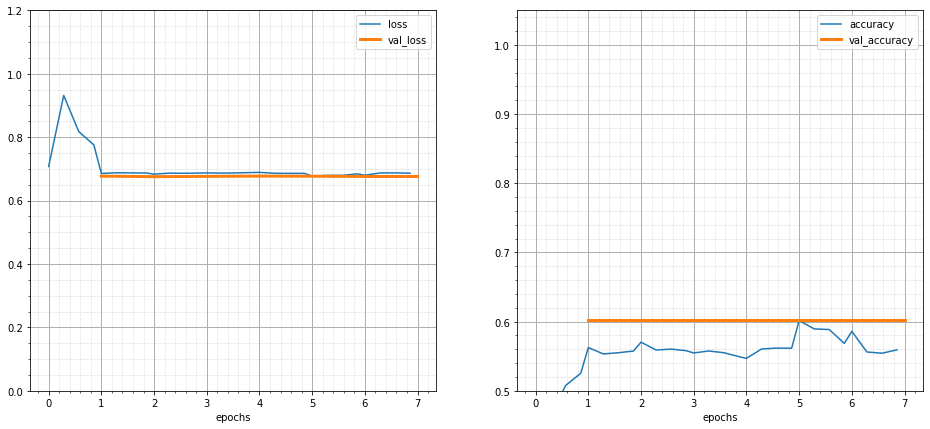

Epoch 8/12

Epoch 00008: LearningRateScheduler setting learning rate to 0.00027993599999999994.
21/35 [=================>............] - ETA: 1s - loss: 0.6854 - accuracy: 0.5621

KeyboardInterrupt: ignored

In [ ]:
training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

In [ ]:
model = tf.keras.Sequential(
  [
      tf.keras.layers.Reshape(input_shape=(512,), target_shape=(16, 16, 2)),
      tf.keras.layers.Conv2D(kernel_size=4, filters=12,
                             activation='relu'),
      tf.keras.layers.Conv2D(kernel_size=8, filters=24,
                             activation='relu', strides=2),
      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(100, activation='relu'),
      tf.keras.layers.Dropout(0.4),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# print model layers
model.summary()

# utility callback that displays training curves
plot_training = PlotTraining(sample_rate=10, zoom=1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 16, 16, 2)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 13, 13, 12)        396       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 24)          18456     
_________________________________________________________________
flatten_1 (Flatten)          (None, 216)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               21700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                

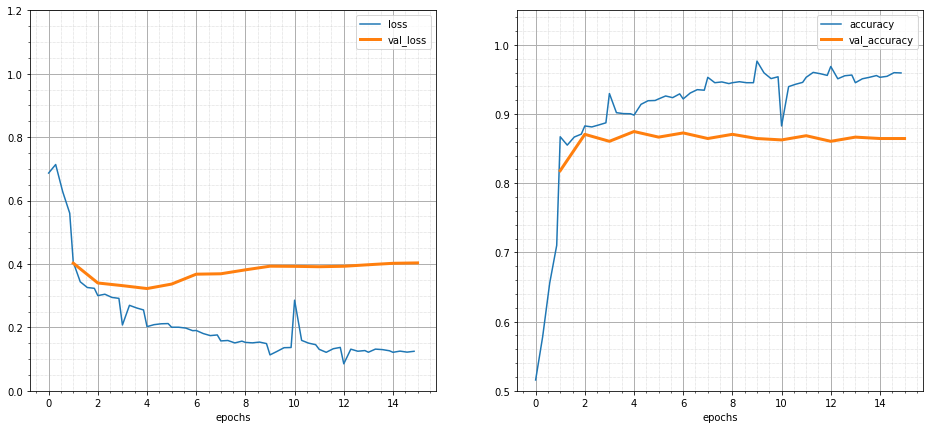

In [ ]:
training_dataset = get_training_ds(training_features, training_labels)

validation_dataset = get_validation_ds(test_features, test_labels)

history = model.fit(training_dataset,
                    steps_per_epoch=steps_per_epoch,
                    epochs=EPOCHS,
                    validation_data=validation_dataset,
                    validation_steps=1,
                    callbacks=[plot_training, lr_decay_callback])

VISUALIZATION OF THE PREDICTIONS

In [ ]:
for validation_images, validation_labels in validation_dataset:
  validation_images = validation_images.numpy()
  validation_labels = validation_labels.numpy()
  break

In [ ]:
predictions = model.predict(validation_images, steps = 1)
predicted_labels = list()

for pred in predictions:
  if pred[0] < 0.25:
    predicted_labels.append(0)
  else:
    predicted_labels.append(1)

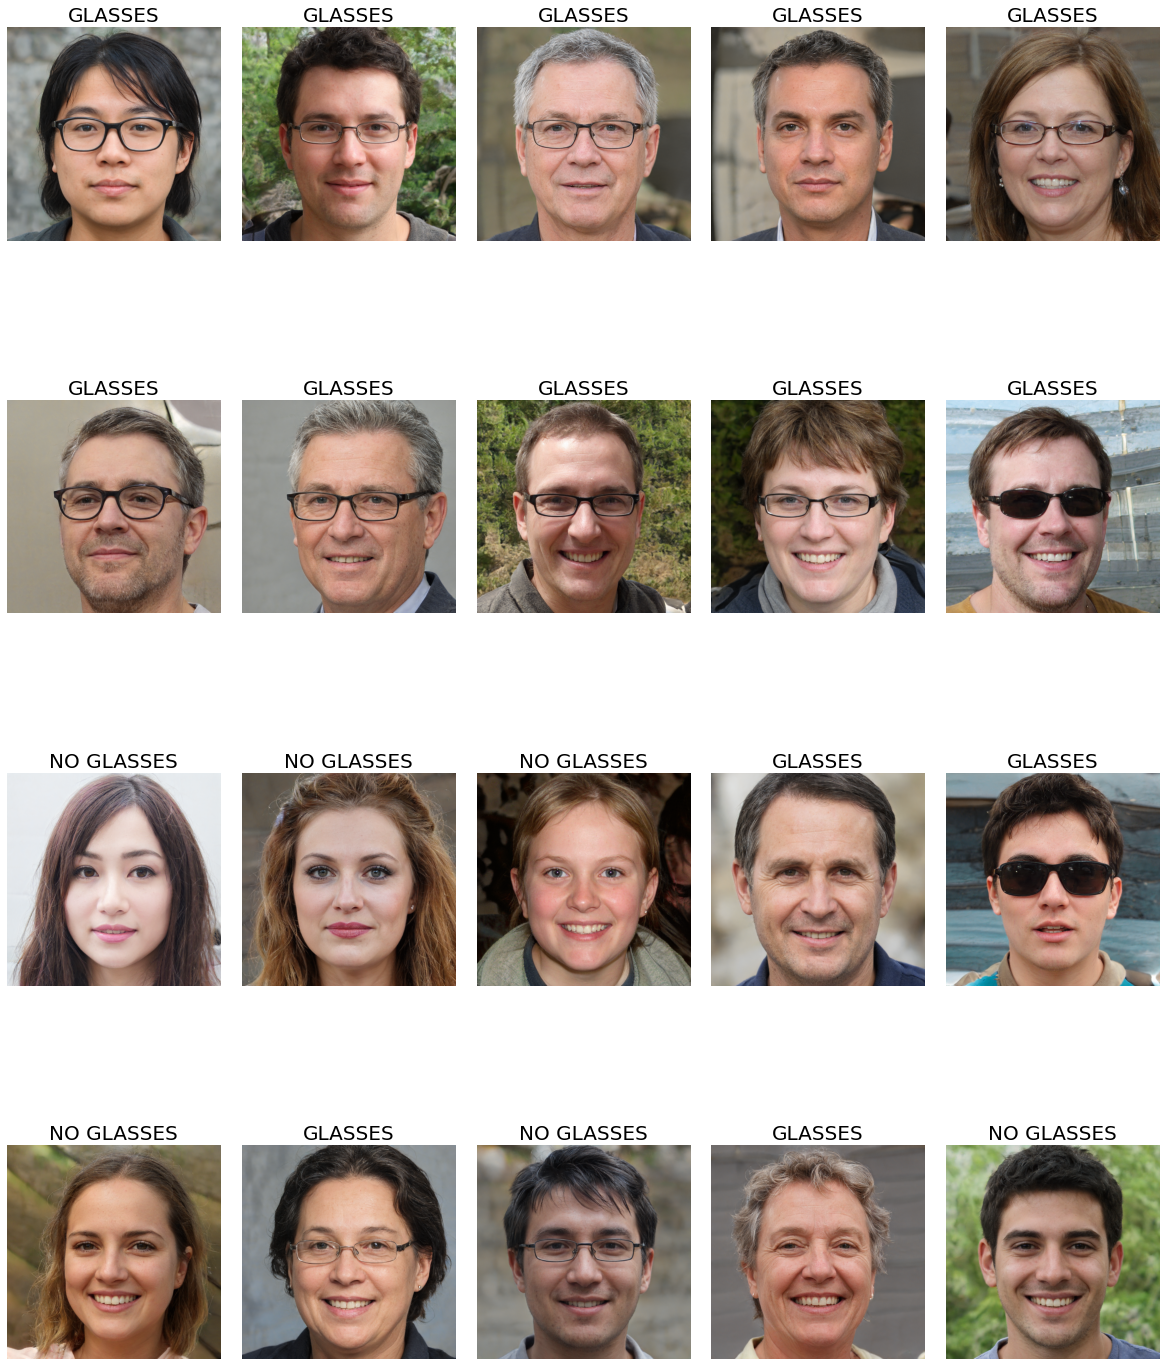

In [ ]:
visualize_image(validation_images, predicted_labels, test_dict, 20)

COSE DA FARE:



*   cambiare le funzioni di learning prese dal prof e togliere schema learning rate
*   segnarsi bene quale modello utilizzare (segnarsi i valori delle prestazioni)
*    giustificare le scelte fatte a livello di: attivation func, num neuroni, num batch, num epoch, over fitting, tipo modello, loss, optimizer, learning rate decay
* capire se da github scarica anche il notebook dentro al notebook
* refactor generale e commentare il codice



In [ ]:
#PROVO AD AUMENTARE TEST SET

second_train = pd.read_csv(train_file_path).copy()
second_train = second_train.set_index('id')

real_train_f = second_train.drop([x for x in range(4001, 4501)])

real_train_l = real_train_f.pop('glasses')
real_train_f.reset_index(drop=True, inplace=True)
real_train_l.reset_index(drop=True, inplace=True)


test_train = second_train[4000:4501]

#PROVO AD AUMENTARE TEST SET

second_test = pd.read_csv(test_file_path).copy()
second_test = second_test.set_index('id')

real_test_f = second_test.append(test_train, ignore_index=True)
real_test_l = real_test_f.pop('glasses')
real_test_l .reset_index(drop=True, inplace=True)

training_features = real_train_f
training_labels = real_train_l
test_features = real_test_f
test_labels = real_test_l